# [Team 06] ProjF: Handwriting Recognition Classify and Convert Handwritten Text

**Michał Stepien** *Email: mstepie@ncsu.edu* **Om Rajyaguru** *Email: orajyag@ncsu.edu* **Jose Molina-Melendez** *Email: jmmolina@ncsu.edu*

Dataset Summary
There are six different splits provided in this dataset. A short summary of the dataset is provided below:

EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.
EMNIST Balanced:  131,600 characters. 47 balanced classes.
EMNIST Letters: 145,600 characters. 26 balanced classes.
EMNIST Digits: 280,000 characters. 10 balanced classes.
EMNIST MNIST: 70,000 characters. 10 balanced classes.
The full complement of the NIST Special Database 19 is available in the ByClass and ByMerge splits. The EMNIST Balanced dataset contains a set of characters with an equal number of samples per class. The EMNIST Letters dataset merges a balanced set of the uppercase and lowercase letters into a single 26-class task. The EMNIST Digits and EMNIST MNIST dataset provide balanced handwritten digit datasets directly compatible with the original MNIST dataset.

Import some libs we'll need.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image, ImageShow
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras import backend as K
from keras.constraints import maxnorm
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

Lets load the **EMNIST** data set and normalize.

In [ ]:
X_test, y_test = tfds.as_numpy(tfds.load(
    'emnist',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

X_train, y_train = tfds.as_numpy(tfds.load(
    'emnist',
    split='train',
    batch_size=-1,
    as_supervised=True,
))




# Normalization
perform grayscale normalization

CNN converge faster on [0..1] data than on [0..255].

In [ ]:
#Normalize
# Convert data to numpy arrays and normalize images to the interval [0, 1]
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train)
X_test = np.array(X_test) / 255.0
y_test = np.array(y_test)

# Data Pre-Processing

Reshape all images into  **28x28** for pre-processing

<function matplotlib.pyplot.show>

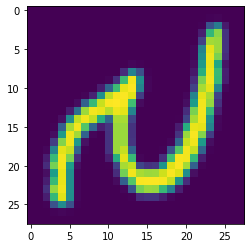

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)

#Display a random image
plt.imshow(X_train[0])
plt.show

<function matplotlib.pyplot.show>

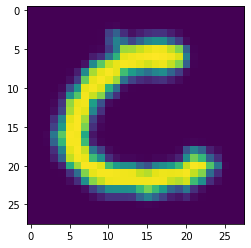

In [ ]:
#train data
for t in range(697932):
    X_train[t]=np.transpose(X_train[t])
    
#check
plt.imshow(X_train[0])
plt.show

#test data  
for t in range(116323):
    X_test[t]=np.transpose(X_test[t])

#check
plt.imshow(X_test[1])
plt.show


#check last image
m = X_train[697931]
plt.imshow(m)
plt.show

### Image preprocessing / Data Agumentation

reverse and rotate all train and test images per recommendation of dataset.

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement:

Without data augmentation an accuracy obtained of xx.xxx%
With data augmentation achieved xx.xx% of accuracy

### Reshape train and test data again for input into model. Also hotencode data.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 784,1)
X_test = X_test.reshape(X_test.shape[0], 784,1)

In [ ]:
def reshape(inputSet):
    outputSet = []
    for image in inputSet:
        outputSet.append(image.reshape(-1))
    return np.asarray(outputSet)

train_images = X_train.astype('float32')
test_images = X_test.astype('float32')

train_images = reshape(train_images)
test_images = reshape(test_images)

train_labels = np_utils.to_categorical(y_train, 62)
test_labels = np_utils.to_categorical(y_test, 62)

K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


# Split training and valdiation set
splitting the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=0)
train_images.shape, validation_images.shape, train_labels.shape, validation_labels.shape

((628138, 784), (69794, 784), (628138, 62), (69794, 62))

### Create Baseline Model

In [ ]:
model_baseline = Sequential()

model_baseline.add(Reshape((28,28,1), input_shape=(784,)))

model_baseline.add(Convolution2D(32, (5,5),activation='relu'))
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
model_baseline.add(Flatten())

model_baseline.add(Dense(62, activation='softmax'))

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_baseline.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Create Enhanced Model with Early Stopping

In [ ]:
#lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
my_callbacks = [
                EarlyStopping(),
                #ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.00001, verbose=1),
                ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1),
                #ModelCheckpoint(filepath = 'my_model.h5', verbose=1, save_best_only=True, save_weights_only=False)
                ModelCheckpoint(filepath = 'my_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
                ]

model = Sequential()

model.add(Reshape((28,28,1), input_shape=(784,)))

model.add(Convolution2D(32, (5,5), input_shape=(28,28,1),
                            activation='relu',padding='same',
                            kernel_constraint=maxnorm(3)))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))

model.add(Dense(62, activation='softmax'))

opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model2=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model2.add(Reshape((28,28,1), input_shape=(784,)))
model2.add(Convolution2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model2.add(Convolution2D(filters=64, kernel_size = (3,3), activation="relu"))

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Convolution2D(filters=128, kernel_size = (3,3), activation="relu"))
model2.add(Convolution2D(filters=128, kernel_size = (3,3), activation="relu"))

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())    
model2.add(Convolution2D(filters=256, kernel_size = (3,3), activation="relu"))
    
model2.add(MaxPooling2D(pool_size=(2,2)))
    
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(512,activation="relu"))
    
model2.add(Dense(62,activation="softmax"))

opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])   




In [ ]:
# With data augmentation to prevent overfitting

#datagen = ImageDataGenerator(
      #  featurewise_center=False,  # set input mean to 0 over the dataset
      #  samplewise_center=False,  # set each sample mean to 0
      #  featurewise_std_normalization=False,  # divide inputs by std of the dataset
      #  samplewise_std_normalization=False,  # divide each input by its std
      #  zca_whitening=False,  # apply ZCA whitening
      #  rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
      #  zoom_range = 0.1, # Randomly zoom image 
      #  width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
      #  height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
      #  horizontal_flip=False,  # randomly flip images
      #  vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
#train_gen = datagen.flow(train_images, train_labels, batch_size=64)
#test_gen = datagen.flow(validation_images, validation_labels, batch_size=64)

Lets visualize our models

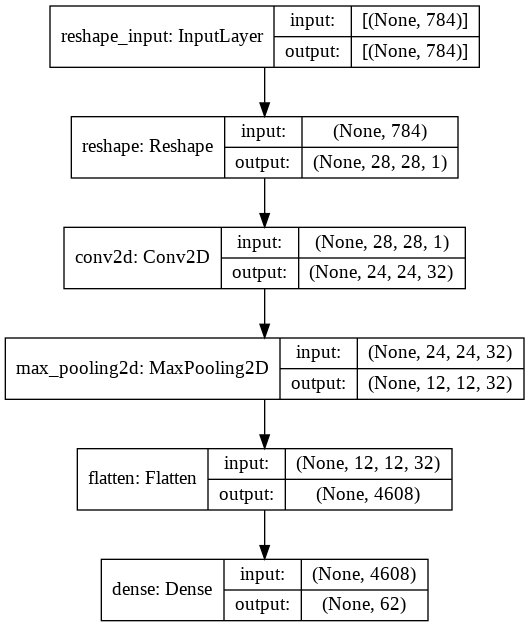

In [ ]:
plot_model(model_baseline, show_shapes=True, show_layer_names=True)

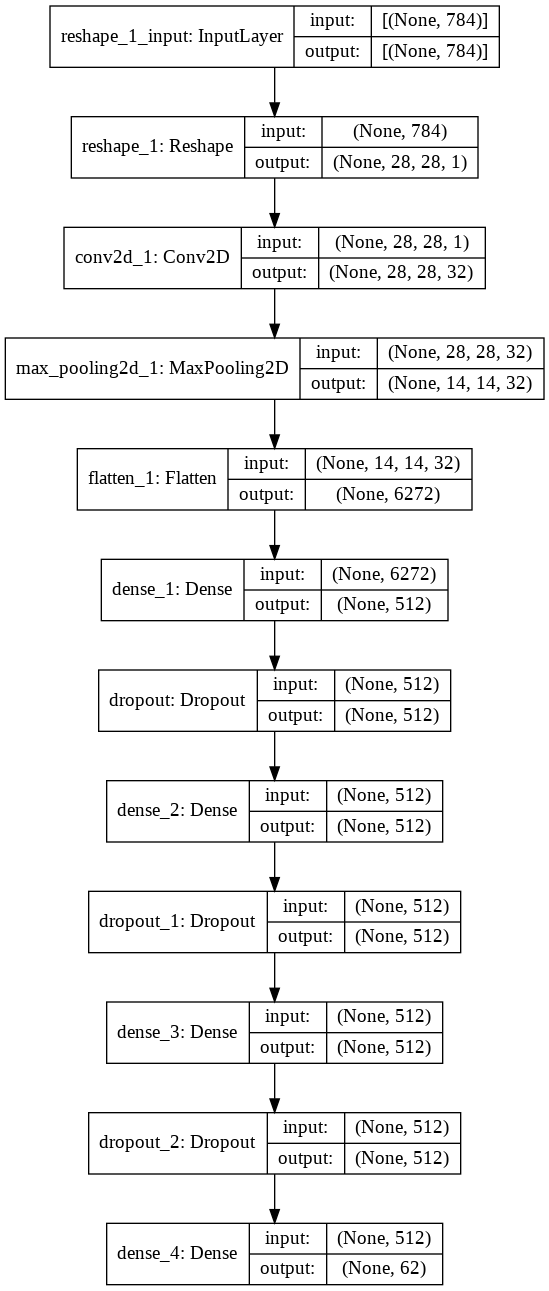

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Training of model and evaluation

In [ ]:
print(model_baseline.summary())
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 62)                285758    
Total params: 286,590
Trainable params: 286,590
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)           

In [ ]:
history_baseline = model_baseline.fit(train_images,train_labels,validation_data=(validation_images, validation_labels), batch_size=520, epochs=10)

Epoch 1/10
1208/1208 [==============================] - 44s 12ms/step - loss: 1.0736 - accuracy: 0.7051 - val_loss: 0.5404 - val_accuracy: 0.8230
Epoch 2/10
1208/1208 [==============================] - 14s 12ms/step - loss: 0.5140 - accuracy: 0.8297 - val_loss: 0.4881 - val_accuracy: 0.8319
Epoch 3/10
1208/1208 [==============================] - 14s 12ms/step - loss: 0.4664 - accuracy: 0.8412 - val_loss: 0.4662 - val_accuracy: 0.8411
Epoch 4/10
1208/1208 [==============================] - 14s 12ms/step - loss: 0.4428 - accuracy: 0.8483 - val_loss: 0.4522 - val_accuracy: 0.8421
Epoch 5/10
1208/1208 [==============================] - 14s 12ms/step - loss: 0.4229 - accuracy: 0.8525 - val_loss: 0.4453 - val_accuracy: 0.8476
Epoch 6/10
1208/1208 [==============================] - 14s 12ms/step - loss: 0.4091 - accuracy: 0.8557 - val_loss: 0.4384 - val_accuracy: 0.8488
Epoch 7/10
1208/1208 [==============================] - 14s 12ms/step - loss: 0.3985 - accuracy: 0.8596 - val_loss: 0.4340 -

In [ ]:
history = model.fit(train_images,train_labels,validation_data=(validation_images, validation_labels), batch_size=520, epochs=10, callbacks=my_callbacks)
#history = model.fit(train_images,train_labels,validation_data=(validation_images, validation_labels), batch_size=128, epochs=20)

Epoch 1/10
1208/1208 [==============================] - 30s 24ms/step - loss: 1.3351 - accuracy: 0.6324 - val_loss: 0.4556 - val_accuracy: 0.8392

Epoch 00001: val_accuracy improved from -inf to 0.83924, saving model to my_model.h5
Epoch 2/10
1208/1208 [==============================] - 28s 23ms/step - loss: 0.5535 - accuracy: 0.8164 - val_loss: 0.4166 - val_accuracy: 0.8498

Epoch 00002: val_accuracy improved from 0.83924 to 0.84977, saving model to my_model.h5
Epoch 3/10
1208/1208 [==============================] - 28s 23ms/step - loss: 0.4895 - accuracy: 0.8333 - val_loss: 0.4018 - val_accuracy: 0.8551

Epoch 00003: val_accuracy improved from 0.84977 to 0.85513, saving model to my_model.h5
Epoch 4/10
1208/1208 [==============================] - 28s 23ms/step - loss: 0.4605 - accuracy: 0.8405 - val_loss: 0.3875 - val_accuracy: 0.8581

Epoch 00004: val_accuracy improved from 0.85513 to 0.85813, saving model to my_model.h5
Epoch 5/10
1208/1208 [==============================] - 28s 23m

In [ ]:
history2 = model2.fit(train_images,train_labels,validation_data=(validation_images, validation_labels), batch_size=520, epochs=10, callbacks=my_callbacks)

#history2 = model.fit_generator(train_gen, 
                             # epochs = 10, 
                             # steps_per_epoch = train_images.shape[0] // 64,
                             # validation_data = test_gen,
                             # validation_steps = validation_images.shape[0] // 64)

Epoch 1/10
1208/1208 [==============================] - 115s 93ms/step - loss: 0.5943 - accuracy: 0.8113 - val_loss: 0.3956 - val_accuracy: 0.8539

Epoch 00001: val_accuracy did not improve from 0.86460
Epoch 2/10
1208/1208 [==============================] - 111s 92ms/step - loss: 0.3587 - accuracy: 0.8668 - val_loss: 0.3641 - val_accuracy: 0.8643

Epoch 00002: val_accuracy did not improve from 0.86460
Epoch 3/10
1208/1208 [==============================] - 111s 92ms/step - loss: 0.3347 - accuracy: 0.8735 - val_loss: 0.3582 - val_accuracy: 0.8670

Epoch 00003: val_accuracy improved from 0.86460 to 0.86704, saving model to my_model.h5
Epoch 4/10
1208/1208 [==============================] - 111s 92ms/step - loss: 0.3164 - accuracy: 0.8795 - val_loss: 0.3544 - val_accuracy: 0.8666

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00004: val_accuracy did not improve from 0.86704
Epoch 5/10
1208/1208 [==============================] - 112s 92ms/step - 

In [ ]:
#evaluating baseline model on validation data.
scores_baseline = model_baseline.evaluate(validation_images,validation_labels, verbose = 0)
print("Baseline Accuracy: %.2f%%"%(scores_baseline[1]*100))

#evaluating enhanced model on validation data.
scores = model.evaluate(validation_images,validation_labels, verbose = 0)
print("Enhanced Model 1 Accuracy: %.2f%%"%(scores[1]*100))
scores = model2.evaluate(validation_images,validation_labels, verbose = 0)
print("Enhanced Model 2 Accuracy: %.2f%%"%(scores[1]*100))

Baseline Accuracy: 85.07%
Enhanced Model 1 Accuracy: 86.41%
Enhanced Model 2 Accuracy: 87.81%


## Creating model history graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


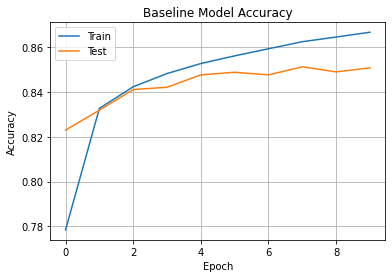

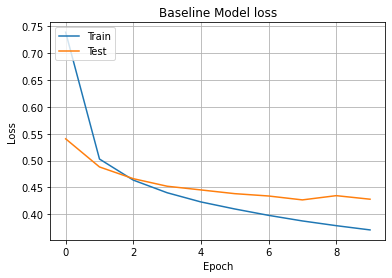

In [ ]:
print(history_baseline.history.keys())
# summarize history for accuracy
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Baseline Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()
# summarize history_baseline for loss
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Baseline Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


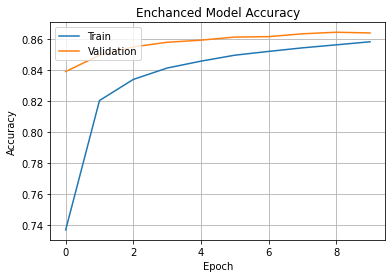

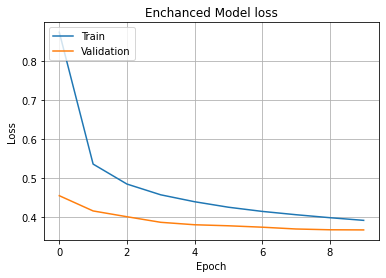

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Enchanced Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Enchanced Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

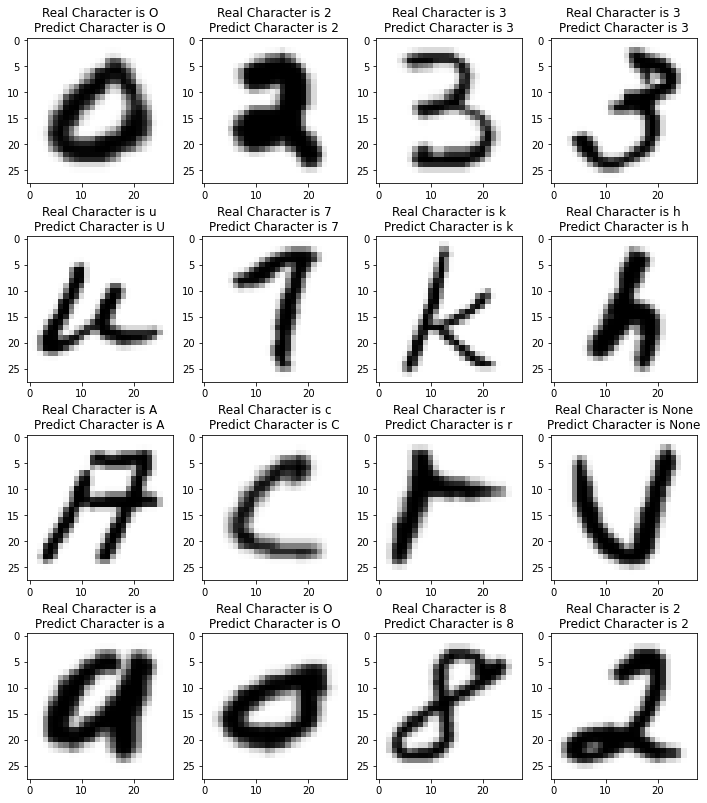

In [ ]:
classMap =	{
  0: "0",
  1: "1",
  2: "2",
  3: "3",
  4: "4",
  5: "5",
  6: "6",
  7: "7",
  8: "8",
  9: "9",
  10: "A",
  11: "B",
  12: "C",
  13: "D",
  14: "E",
  15: "F",
  16: "G",
  17: "H",
  18: "I",
  19: "J",
  20: "K",
  21: "L",
  22: "M",
  23: "N",
  24: "O",
  25: "P",
  26: "Q",
  27: "R",
  28: "S",
  29: "T",
  30: "U",
  32: "V",
  32: "W",
  33: "X",
  34: "Y",
  35: "Z",
  36: "a",
  37: "b",
  38: "c",
  39: "d",
  40: "e",
  41: "f",
  42: "g",
  43: "h",
  44: "i",
  45: "j",
  46: "k",
  47: "l",
  48: "m",
  49: "n",
  50: "o",
  51: "p",
  52: "q",
  53: "r",
  54: "s",
  55: "t",
  56: "u",
  57: "v",
  58: "w",
  59: "x",
  60: "y",
  61: "z",
}

y_pred = model.predict(test_images)
X_test__ = test_images.reshape(test_images.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Character is {classMap.get(int(test_labels[i].argmax()))}\nPredict Character is {classMap.get(int(y_pred[i].argmax()))}");

# Confusion Matrix

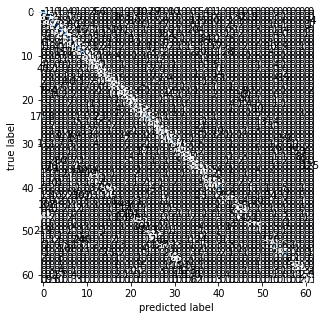

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      5778
           1       0.69      0.90      0.78      6330
           2       0.95      0.97      0.96      5869
           3       0.99      0.99      0.99      5969
           4       0.96      0.98      0.97      5619
           5       0.97      0.92      0.94      5190
           6       0.98      0.97      0.97      5705
           7       0.98      1.00      0.99      6139
           8       0.98      0.97      0.98      5633
           9       0.92      0.98      0.95      5686
          10       0.93      0.97      0.95      1062
          11       0.90      0.95      0.92       648
          12       0.76      0.96      0.85      1739
          13       0.85      0.90      0.87       779
          14       0.96      0.96      0.96       851
          15       0.77      0.97      0.86      1440
          16       0.94      0.87      0.91       447
          17       0.91    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 5))
plt.show()

from sklearn.metrics import classification_report , accuracy_score
print(classification_report(y_true, pred))

Lets predict a single image using the model of choice.

In [ ]:
predictingModel = model_baseline
#predictingModel = model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Mode Prediction is: [22]


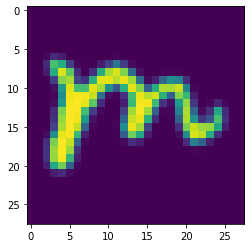

In [ ]:
m = X_test[754].reshape(28,28)
plt.imshow(m)
plt.show
print('Mode Prediction is: '+str(predictingModel.predict_classes(X_test[754].reshape(1,784))))

In [ ]:
print(y_test[315])

32


# Interactive Live Testing

Lets set up a nice canvas for folks to draw using thier mouse. This will be a mouse generated image, so it won't be real handwritting per say. But lets try it anyways.

In [ ]:
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finished</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillStyle = "black";
ctx.fillRect(0, 0, 448, 448);
ctx.strokeStyle = "white";
ctx.lineCap = 'round';
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=224, h=224, line_width=10):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

You can just keep calling `draw()` function, as it will let you draw on screen and hit the `Finished` button to override the file so it can be used for prediction.


In [ ]:
draw()

3393

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model prediction is: 3


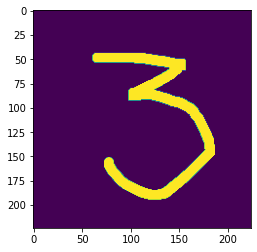

In [ ]:
image = cv2.imread("drawing.png")
#cv2_imshow(image)
image = cv2.resize(image,(28,28))
#cv2_imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
data = np.asarray(gray)
data=data/255.0
y_pred = predictingModel.predict_classes(np.expand_dims(data, 0))
print(f"Model prediction is: {classMap.get(int(y_pred))}")
img = Image.open('drawing.png').convert("L")
plt.imshow(img)
plt.show()